In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt


In [60]:
from src.models import FCN, FCN_with_last_activation
from src.data_handler import DataHandler, RandomSamplingDataHandler
from src.constants import ALPHA
from src.experiment_run import Run

In [45]:
import astropy.units as u

In [46]:
torch.manual_seed(123)

In [47]:
data = np.load('data/test1.npy').T
data.shape

(2000, 10000)

In [48]:
params = pd.read_csv('data/params1.txt', sep=' ')
params = params.values
params.shape

(2000, 2)

In [49]:
dt = 50*u.yr
t_steps = 10000

# define the Universe time
u_time = np.arange(t_steps) # *dt.value

In [10]:
dt.value

50.0

In [50]:
x = torch.tensor(u_time).float().view(-1,1)
y = torch.tensor(data[0]).float().view(-1,1)

In [51]:
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [52]:
nH, gamma = params[0].astype(float)

def physics_loss_fn(x, y, loss_coef=1.):
    # compute dy/dx
    dy = torch.autograd.grad(y, x, torch.ones_like(y), create_graph=True)[0]
    
    # compute the physic loss
    ode = dy * dt.value - (1 - y) * gamma - ALPHA * nH * y ** 2

    return loss_coef * torch.mean(ode ** 2)

In [17]:
model = FCN([1, 32, 32, 32, 32, 32, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('model_for_one_set_of_params_no_physics')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model
run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = None

run.train(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 5000/5000 [02:59<00:00, 27.84it/s]


In [18]:
run.score()

tensor(-0.3648)

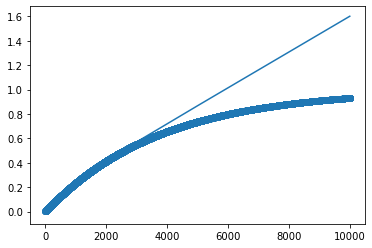

In [19]:
plt.plot(x, model(x).detach().numpy())
plt.scatter(x,y)

In [57]:
model = FCN([1, 32, 32, 32, 32, 32, 1], torch.nn.ELU)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('baseline_with_phys_loss_elu_1000_epochs')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1.0)

run.train(1000)

  0%|          | 1/1000 [00:00<02:04,  8.02it/s]

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 1000/1000 [02:15<00:00,  7.37it/s]


In [58]:
run.score()

tensor(0.7918)

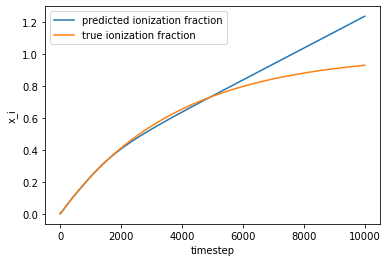

In [59]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

Our model provides a good approximation on early timesteps but it fails on the last timesteps, predicting linear dependence instead of constant. To approximate the plato at the end of the ionization process, we can change activation to Softsign. It is a smooth function, bounded by 1.0 for large values on x-axis

In [53]:
model = FCN([1, 32, 32, 32, 32, 32, 1], torch.nn.Softsign)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('baseline_with_phys_loss_softsign_1000_epochs')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1.0)

run.train(1000)

  0%|          | 1/1000 [00:00<01:57,  8.54it/s]

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 1000/1000 [01:27<00:00, 11.47it/s]


In [54]:
run.score()

tensor(0.3797)

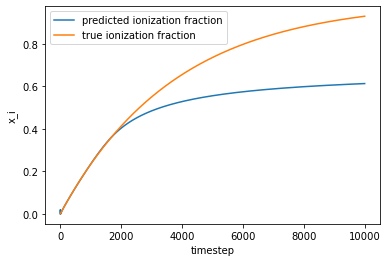

In [56]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()

To avoid the degradation in quality, we can still use ELU after all fully-connected layers except for the last one, where we apply Softsign to get the model output. So we get benefits of both activations: ELU is better from the optimization perspective, Softsign at the end approximates relaxation of the ionization process for the large time values

In [61]:
model = FCN_with_last_activation([1, 32, 32, 32, 32, 32, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=20,)

run = Run('baseline_with_phys_loss_hybrid_activation_1000_epochs')

run.data_handler = DataHandler(x, y, 2000, 20)
run.model = model

run.optimizer = optimizer
run.scheduler = scheduler
run.data_loss = torch.nn.MSELoss()
run.physics_loss = lambda x, y: physics_loss_fn(x, y, loss_coef=1.0)

run.train(1000)

  0%|          | 1/1000 [00:00<02:38,  6.31it/s]

torch.Size([100, 1]) torch.Size([9900, 1])


100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


In [62]:
run.score()

tensor(0.9129)

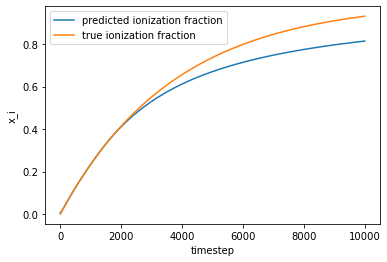

In [63]:
plt.plot(x, model(x).detach().numpy(), label="predicted ionization fraction")
plt.plot(x, y, label="true ionization fraction")
plt.xlabel("timestep")
plt.ylabel("x_i")
plt.legend()